# Traffic Sign Recognition

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
import matplotlib.pyplot as plt

#MANAGEMENT PURPOSES ONLY
from tqdm.notebook import tqdm

In [2]:
print(tf.config.list_physical_devices())
tf.test.gpu_device_name()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


''

In [3]:
from platform import python_version

print(python_version())

3.8.12


## Data management

In [4]:
data_path = r"./DATASET/"
img_size = 32

In [5]:
def load_data(dataset):
    images = []
    classes = []    
    rows = pd.read_csv(dataset)
    rows = rows.sample(frac=1).reset_index(drop=True)
            
    with tqdm(total=len(rows)+1) as pbar:
    
        for i, row in rows.iterrows():
            img_class = row["ClassId"]
            img_path = row["Path"]        
            image = os.path.join(data_path, img_path)

            image = cv2.imread(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_rs = cv2.resize(image, (img_size, img_size), 3)        

            R, G, B = cv2.split(image_rs)     

            img_r = cv2.equalizeHist(R)
            img_g = cv2.equalizeHist(G)
            img_b = cv2.equalizeHist(B)        

            new_image = cv2.merge((img_r, img_g, img_b))

            pbar.update(1)

            images.append(new_image)
            classes.append(img_class)
            
        pbar.container.children[-2].style.bar_color = '#00FF00' # Set bar to green color at end
    
    X = np.array(images)
    y = np.array(classes)
    
    return (X, y)

### Load data 

In [6]:
train_data_path = data_path + "Train.csv"
test_data_path = data_path + "Test.csv"


(Xtrain, Ytrain) = load_data(train_data_path)
(Xtest, Ytest) = load_data(test_data_path)

  0%|          | 0/39210 [00:00<?, ?it/s]

  0%|          | 0/12631 [00:00<?, ?it/s]

### Normalise data

In [7]:
Xtrain = Xtrain.astype("float32") / 255.0
Xtest = Xtest.astype("float32") / 255.0

num_labels = len(np.unique(Ytrain))
Ytrain = to_categorical(Ytrain, num_labels)
Ytest = to_categorical(Ytest, num_labels)

class_totals = Ytrain.sum(axis=0)
class_weight = class_totals.max() / class_totals

## Hyper parameters

In [8]:
epochs = 25
learning_rate = 0.001
batch_size = 64

#### Data augmentation

 Data augmentation creates modified versions of the images in our dataset. It allows us to add images to our dataset without us having to collect new ones

In [9]:
data_augmentation = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.15,
    horizontal_flip = False,
    vertical_flip = False
)

## Training Model

In [10]:
class RoadSignClassifier:
    
    def createCNN(width, height, depth, classes):
        
        """
         Using the Sequential API
         create the model layer-by-layer
        """
        model = Sequential()
        inputShape = (height, width, depth)
        
        
        """
         First convolutional layer. Define output dim
         Activation function “relu”
        """
        model.add(Conv2D(8, (5, 5), input_shape=inputShape, activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        """
        Batch normalization. It just speeds up training.
        """
        model.add(Conv2D(16, (3, 3), activation="relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(16, (3, 3), activation="relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
 
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization())
        
        """
        The output in the final dense layer is equal to the number of classes that we have.
        """
        
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(512, activation="relu"))        
        
        model.add(Dense(classes, activation="softmax"))
        
        return model

In [11]:
model = RoadSignClassifier.createCNN(
    width = img_size, 
    height = img_size, 
    depth = 3, 
    classes = len(class_totals)
)

optimizer = Adam(
    lr = learning_rate, 
    decay = (learning_rate / epochs)
)

In [12]:
model.compile(
    optimizer = optimizer, 
    loss = "categorical_crossentropy", 
    metrics = ["accuracy"]
)

In [13]:
fit = model.fit(

        data_augmentation.flow(
            Xtrain, 
            Ytrain, 
            batch_size = batch_size
        ), 
        epochs = epochs,

        validation_data = (Xtest, Ytest),

        class_weight = dict(enumerate(class_weight.flatten(), 0)),

        verbose=1
)

Epoch 1/25
613/613 [==============================] - 26s 42ms/step - loss: 4.4879 - accuracy: 0.4541 - val_loss: 0.9525 - val_accuracy: 0.6908
Epoch 2/25
613/613 [==============================] - 26s 42ms/step - loss: 2.0680 - accuracy: 0.6965 - val_loss: 0.6692 - val_accuracy: 0.7890
Epoch 3/25
613/613 [==============================] - 26s 42ms/step - loss: 1.3980 - accuracy: 0.7880 - val_loss: 0.4114 - val_accuracy: 0.8728
Epoch 4/25
613/613 [==============================] - 26s 43ms/step - loss: 1.0434 - accuracy: 0.8390 - val_loss: 0.5289 - val_accuracy: 0.8410
Epoch 5/25
613/613 [==============================] - 28s 45ms/step - loss: 0.8691 - accuracy: 0.8676 - val_loss: 0.4013 - val_accuracy: 0.8801
Epoch 6/25
613/613 [==============================] - 27s 44ms/step - loss: 0.7412 - accuracy: 0.8872 - val_loss: 0.2993 - val_accuracy: 0.9120
Epoch 7/25
613/613 [==============================] - 27s 44ms/step - loss: 0.6107 - accuracy: 0.9042 - val_loss: 0.5633 - val_accuracy:

In [14]:
score = model.evaluate(Xtest, Ytest, verbose=0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.25752171874046326
Test accuracy:  0.9315914511680603


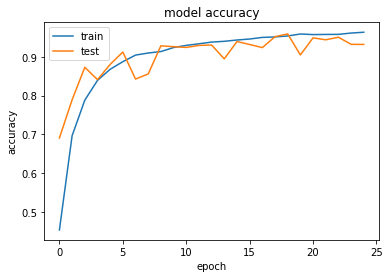

In [15]:
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
model_name = "TSR_Model_96perEpoch35"

In [17]:
model.save(f'./MODELS/{model_name}')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./MODELS/TSR_Model_96perEpoch35\assets


In [18]:
model = models.load_model(f'./MODELS/{model_name}')
model.compile(
    optimizer = optimizer, 
    loss = "categorical_crossentropy", 
    metrics = ["accuracy"]
)

## Prediction

In [19]:
signDict = {}

for i in range(len(Ytrain)):
    
    classs = np.argmax(Ytrain[i])
    
    if classs not in signDict.keys():
        signDict[classs] = i

print(signDict)

{7: 0, 4: 1, 38: 2, 17: 3, 2: 4, 15: 5, 25: 6, 1: 9, 16: 11, 13: 12, 5: 13, 12: 15, 18: 16, 41: 18, 42: 20, 20: 27, 35: 33, 28: 34, 8: 37, 11: 38, 31: 42, 39: 45, 26: 48, 40: 51, 34: 58, 24: 60, 6: 64, 9: 69, 21: 71, 10: 75, 3: 77, 33: 83, 30: 98, 22: 99, 37: 100, 14: 105, 36: 124, 27: 186, 0: 207, 23: 245, 32: 250, 19: 329, 29: 464}


In [138]:
imagePredictionSRC = os.path.join(data_path, "Test/00111.png")

### Load image 

In [139]:
image = cv2.imread(imagePredictionSRC)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [140]:
image_rs = cv2.resize(image, (img_size, img_size), 3)        

R, G, B = cv2.split(image_rs)     

img_r = cv2.equalizeHist(R)
img_g = cv2.equalizeHist(G)
img_b = cv2.equalizeHist(B)        

image = cv2.merge((img_r, img_g, img_b))

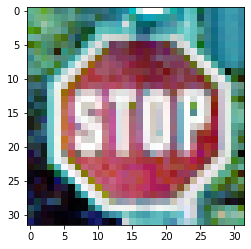

In [141]:
plt.imshow(image)

In [142]:
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
input_arr = input_arr.astype('float32') / 255. 

In [143]:
predictions = model.predict(input_arr)
predicted_class = np.argmax(predictions, axis=-1)[0]

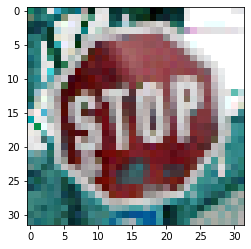

In [144]:
plt.imshow(Xtrain[signDict[predicted_class]])

0.022714972
